# SWOT L3 KaRIn and Nadir Ocean Data Products

This tutorial will introduce you to some sample SWOT L3 data products and show you how to download these data from AVISO and perform basic plots using Python related libraries.

## Tutorial Objectives:
- Present SWOT sample L3 data products (Basic and Expert versions)
- Show you how to find and visualize SWOT Sea Level Anomaly (SLA) data sets from AVISO FTP server
- Download SWOT KaRIn (2D swath) and nadir (along-track) altimetry combined data

#### Import libraries

In [1]:
# Install Cartopy with mamba to avoid discrepancies
! mamba install -q -c conda-forge cartopy

In [2]:
import requests
import numpy as np
import xarray as xr

import os
import ftplib
import getpass
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.geoaxes as cmplgeo
import cartopy.mpl.gridliner as cmplgrid
import matplotlib.pyplot as plt
%matplotlib inline

#### Configuring AVISO FTP Data Access

In [3]:
def ftp_data_access(ftp_path, filename):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'

    try:
        # Prompt for username and password
        username = input("Enter username: ")
        password = getpass.getpass(prompt=f"Enter password for {username}: ")

        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                local_filepath = input("Enter the local directory to save the file: ")
                download_file_from_ftp(ftp, filename, local_filepath)
            else:
                print(f"File {filename} does not exist in the directory.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def download_file_from_ftp(ftp, filename, target_directory):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {local_filepath}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

SWOT L3 Ocean Basic product FTP download







In [17]:
# Define directories
ftp_path = '/swot_beta_products/l3_karin_nadir/1day_orbit/basic/v0_3/'
filename = 'SWOT_L3_LR_SSH_Basic_550_012_20230612T193204_20230612T202309_v0.3.nc'

# FTP download
ftp_data_access(ftp_path, filename)

Enter username:  cyril.germineaud@cnes.fr
Enter password for cyril.germineaud@cnes.fr:  ········


Connection Established 220 192.168.10.119 FTP server ready


Enter the local directory to save the file:  tmp


Downloaded SWOT_L3_LR_SSH_Basic_488_007_20230412T005730_20230412T014836_v0.3.nc to tmp/SWOT_L3_LR_SSH_Basic_488_007_20230412T005730_20230412T014836_v0.3.nc


SWOT L3 Ocean Expert product FTP download

In [18]:
# Define directories
ftp_path = '/swot_beta_products/l3_karin_nadir/1day_orbit/expert/v0_3/'
filename = 'SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v0.3.nc'

# FTP download
ftp_data_access(ftp_path, filename)

Enter username:  cyril.germineaud@cnes.fr
Enter password for cyril.germineaud@cnes.fr:  ········


Connection Established 220 192.168.10.119 FTP server ready


Enter the local directory to save the file:  tmp


Downloaded SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v0.3.nc to tmp/SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v0.3.nc


In [23]:
# Set file names
half_orbit_basic = os.path.join('tmp/','SWOT_L3_LR_SSH_Basic_488_007_20230412T005730_20230412T014836_v0.3.nc')
half_orbit_expert = os.path.join('tmp/','SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v0.3.nc')

In [24]:
# Select regional boundaries
lolabox = [-90, -30, 20, 60] # Gulf Stream

## Basic product content
This product contains two versions of SLA (ssha in the datasets). The ssha_noiseless field is obtained by denoising the ssha field. The mean dynamic topography is also included in order to derive the absolute dynamic topography. Finally, the nadir sea level anomaly has been combined in the KaRIn swath, with the i_num_line and i_num_pixel fields indexing its location in the grid.


In [25]:
ds_basic =  xr.open_dataset(half_orbit_basic)
[v for v in ds_basic.variables]

['time',
 'latitude',
 'longitude',
 'mdt',
 'ssha',
 'ssha_noiseless',
 'i_num_line',
 'i_num_pixel']

## Expert product content
This product contains all the Basic fields, and additionnal fields that allows
a deeper investigation by Expert users. This includes the corrections used for
the SLA and the currents (absolute and relative) computed for the denoised SLA.

In [26]:
ds_expert = xr.open_dataset(half_orbit_expert)
[v for v in ds_expert.variables if v not in ds_basic]
ds_expert = ds_expert.assign_coords(longitude=(((ds_expert.longitude + 180) % 360) - 180))

# Select data over the region
lolasubset = (
(ds_expert.longitude > lolabox[0]) &
(ds_expert.longitude < lolabox[1]) &
(ds_expert.latitude > lolabox[2]) &
(ds_expert.latitude < lolabox[3]))

ds_expert_sub = ds_expert.where(lolasubset, drop=True)

## SWOT nadir data
- The nadir data can be extracted from the dataset using the i_num_line and i_num_pixel indexes.

- The nadir positions and time are an estimation that combines the swath positions and time with
the indexes.

In [27]:
# Build nadir variable
ds_expert["time_nadir"] = ds_expert.time[ds_expert.i_num_line]
ds_expert["longitude_nadir"] = ds_expert.longitude[ds_expert.i_num_line, ds_expert.i_num_pixel]
ds_expert["latitude_nadir"] = ds_expert.latitude[ds_expert.i_num_line, ds_expert.i_num_pixel]
ds_expert["sla_nadir"] = ds_expert.ssha[ds_expert.i_num_line, ds_expert.i_num_pixel]

# Select nadir data over the region (using num_nadir dimension only)
lolasubset_nadir = (
(ds_expert.longitude_nadir > lolabox[0]) &
(ds_expert.longitude_nadir < lolabox[1]) &
(ds_expert.latitude_nadir > lolabox[2]) &
(ds_expert.latitude_nadir < lolabox[3]))

ds_nadir = ds_expert.drop_dims(["num_lines", "num_pixels"]).where(lolasubset_nadir, drop=True)

### Visualize the data: basic SLA plots
Let's visualize SWOT KaRIn abd Nadir data using cartopy.

Adapt this code to visualize other variables or regions, or try importing another file.

/Users/cgermineaud/miniconda3/envs/phys_ocean/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


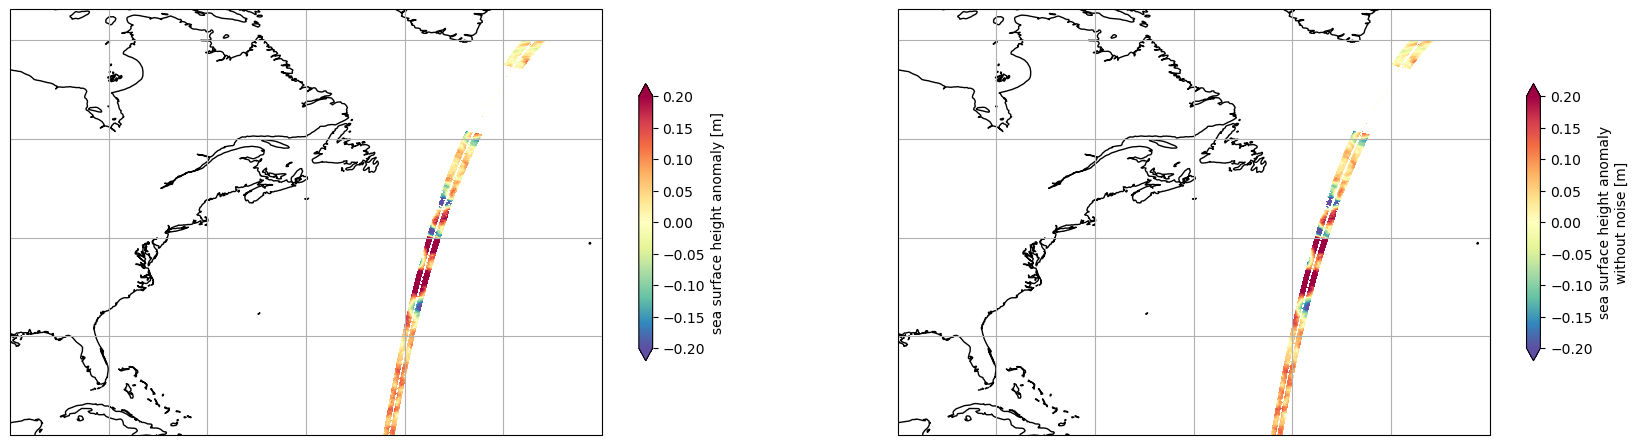

In [28]:
# set figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax1.set_extent(lolabox)
ax2.set_extent(lolabox)
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=-0.2,
    vmax=0.2,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
ds_expert_sub.ssha.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds_expert_sub.ssha_noiseless.plot.pcolormesh(ax=ax2, **plot_kwargs)
#
ax1.coastlines()
ax1.gridlines()
ax2.coastlines()
ax2.gridlines()

Let's plot SWOT Nadir data only using cartopy.

Text(0.5, 0, 'latitude [degrees_north]')

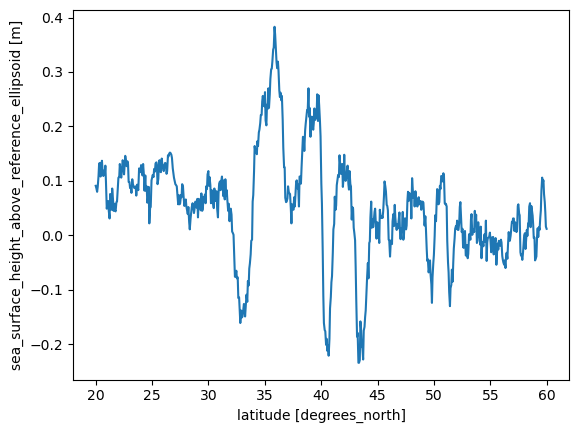

In [29]:
plt.plot(ds_nadir.latitude_nadir.values, ds_nadir.sla_nadir.values)
plt.ylabel(f'{ds_nadir.sla_nadir.attrs["standard_name"]} [{ds_nadir.sla_nadir.attrs["units"]}]')
plt.xlabel(f'{ds_nadir.latitude_nadir.attrs["standard_name"]} [{ds_nadir.latitude_nadir.attrs["units"]}]')

## Remove nadir data from L3 data set
It is possible to remove the nadir data combined with L3 KaRIn data.

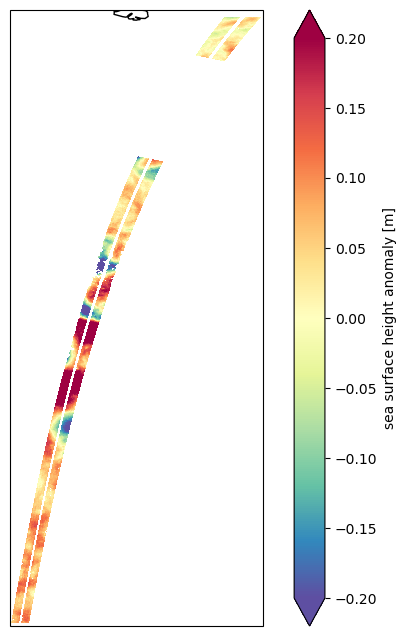

In [30]:
# Masking must be done prior regional subsetting
ssha = ds_expert.ssha
ssha[ds_expert.i_num_line, ds_expert.i_num_pixel] = np.nan

# Regional subsetting
ssha_area = ssha.where(lolasubset, drop=True)

# plot SLA KaRIn data only
del plot_kwargs["cbar_kwargs"]
mesh = ssha_area.plot.pcolormesh(
figsize=(8, 8),
subplot_kws=dict(projection=ccrs.PlateCarree()),
**plot_kwargs)
mesh.axes.coastlines()